In [11]:
# importing libraries
import os
import scipy
import nitime 
import warnings
import subprocess
import numpy as np 
import scipy.io as sio
import scipy.stats as stat
from scipy import stats, signal
import matplotlib.pyplot as plt 
from scipy.sparse import lil_matrix
from nitime.utils import percent_change
from nitime.timeseries import TimeSeries
from nitime.analysis import CorrelationAnalyzer, CoherenceAnalyzer

In [12]:
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


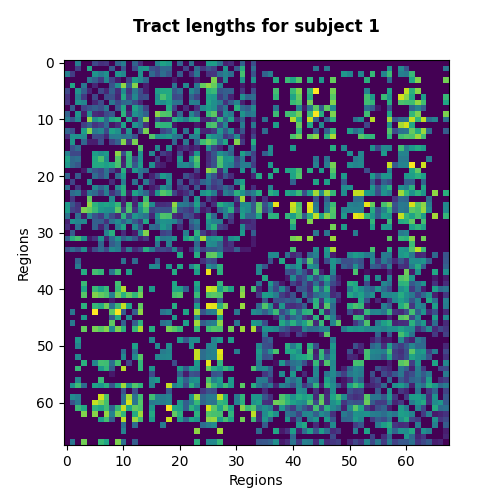

Text(0.5, 1.05, 'Tract lengths for subject 1')

In [34]:
%pylab nbagg
conn=np.loadtxt("./C_Input/sub_SC_distances.txt")
# plot of structural connectivity
plt.imshow(conn) 
plt.xlabel("Regions")
plt.ylabel("Regions")
connectivity_title = "Tract lengths for subject " + "1"
plt.title(connectivity_title, fontweight="bold", fontsize="12", y = 1.05)

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


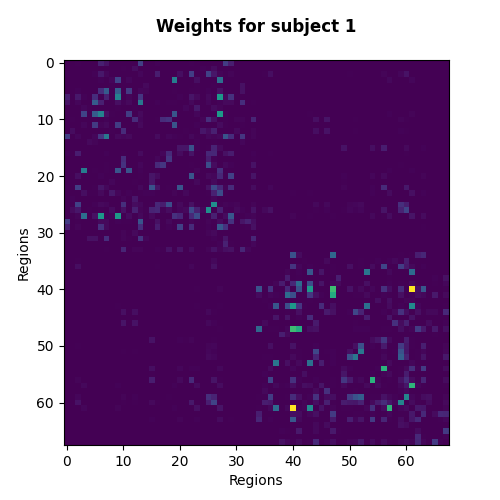

Text(0.5, 1.05, 'Weights for subject 1')

In [32]:
%pylab nbagg
conn=np.loadtxt("./C_Input/sub_SC_weights.txt")
# plot of structural connectivity
plt.imshow(conn) 
plt.xlabel("Regions")
plt.ylabel("Regions")
connectivity_title = "Weights for subject " + "1"
plt.title(connectivity_title, fontweight="bold", fontsize="12", y = 1.05)

In [13]:
def executeC(): 
    # store the return code of the c program(return 0) 
    # and display the output 
    s = subprocess.check_call("gcc ./HCP_Large/tvbii_multicore.c -lpthread -lm -lgsl -lgslcblas -o tvbii; ./tvbii param_set.txt sub 1", shell = True) 

In [14]:
def get_path(group_name, subject_num, test_num):
    # gets the path for the directory corresponding to each combination of group, subject and test
    if subject_num < 10: return "./Data/" + group_name + "0" + str(subject_num) + "/"
    else: return "./Data/" + group_name + str(subject_num) + "/"

In [15]:
def make_input(group_id, subject_id):
    # does all the book-keeping with respect to arranging and channeling the input files
    try : os.remove("./C_Input/sub_SC_weights.txt")
    except : pass
    try: os.remove("./C_Input/sub_SC_distances.txt")
    except: pass
    path = get_path(group_id, subject_id, "T1")
    np.savetxt('./C_Input/sub_SC_weights.txt', np.loadtxt(path + "weights.txt"), delimiter=' ')
    np.savetxt('./C_Input/sub_SC_distances.txt', np.loadtxt(path + "tract_lengths.txt"), delimiter=' ')
    f = open("./C_Input/param_set.txt", "r")
    for line in f:
        temp = line.split()
        break
    f.close()
    # making relavant changes to the parameters file used for simulation
    if (group_id == "CON" and int(subject_id) <= 4) or (group_id == "PAT" and int(subject_id) <= 8):
        TR = 2.1 
    else:
        TR = 2.4
    temp[6] = str(int(TR * 1000 * 200))
    temp[7] = str(int(TR * 1000))
    f = open("./C_Input/param_set.txt", "w") 
    for each in temp:
        f.write(each)
        f.write(" ") 
    f.close()

In [16]:
def getCorrelation(group_id, subject_id):
    # obtains the correlation between empirical functional connectivity and simulated functional connectivity
    input_path_sim = "fMRI.txt"
    input_path_em = get_path(group_id, subject_id, "T1") + "FC.mat"
    em_mat = scipy.io.loadmat(input_path_em)
    em_fc_matrix = em_mat["FC_cc_DK68"]
    sampling_interval = em_mat["TR"][0][0]
    uidx = np.triu_indices(68, 1)
    em_fc_z = np.arctanh(em_fc_matrix)
    em_fc = em_fc_z[uidx]
    tsr = np.loadtxt(input_path_sim)
    T = TimeSeries(tsr, sampling_interval=sampling_interval)
    C = CorrelationAnalyzer(T)
    sim_fc = np.arctanh(C.corrcoef)[uidx]
    sim_fc = np.nan_to_num(sim_fc)
    pearson_corr, _ = stat.pearsonr(sim_fc, em_fc)
    return pearson_corr

In [17]:
def alterGlobalCoupling(G):
    # alters the global coupling value for each iteration of parameter space exploration
    f = open("./C_Input/param_set.txt", "r")
    for line in f:
        temp = line.split()
        break
    f.close()
    temp[1] = str(G) 
    f = open("./C_Input/param_set.txt", "w") 
    for each in temp:
        f.write(each)
        f.write(" ") 
    f.close()

In [18]:
def main():
    # Driver function 
    Subjects = {}
#     Subjects["CON"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
#     Subjects["PAT"] = [1, 2, 3, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25]
    Subjects["CON"] = [1]
    Subjects["PAT"] = []
    tests = ["T1", "T2"]
    g = [(i/10)+0.01 for i in range(0,31,2)]
    g = sorted(g, reverse=True)
    for group_id in Subjects.keys():
        for subject_id in Subjects[group_id]:
            PCorr = [0.0 for i in range(len(g))]
            make_input(group_id, subject_id)
            for i in range(len(g)):
                print("Analysis of Subject: ", group_id + " " + str(subject_id))
                alterGlobalCoupling(g[i])
                executeC()
                PCorr[i] = getCorrelation(group_id, subject_id)
                print("Global Coupling: ", g[i], " and Correlation: ", PCorr[i])
            try : os.remove(get_path(group_id, subject_id, tests[0]) + "/Output/PCorr.txt")
            except : pass
            if not os.path.isdir(get_path(group_id, subject_id, tests[0]) + "/Output"):
                os.mkdir(get_path(group_id, subject_id, tests[0]) + "/Output")
            np.savetxt(get_path(group_id, subject_id, tests[0]) + "/Output/PCorr.txt", np.asarray(PCorr), delimiter = " ")
    os.remove("fMRI.txt")
    os.remove("tvbii")

In [20]:
main()

Analysis of Subject:  CON 1
Global Coupling:  3.01  and Correlation:  0.3287351584057924
Analysis of Subject:  CON 1
Global Coupling:  2.8099999999999996  and Correlation:  0.327854660172137
Analysis of Subject:  CON 1
Global Coupling:  2.61  and Correlation:  0.32717529705775256
Analysis of Subject:  CON 1
Global Coupling:  2.4099999999999997  and Correlation:  0.3268276598680098
Analysis of Subject:  CON 1
Global Coupling:  2.21  and Correlation:  0.327100020474434
Analysis of Subject:  CON 1
Global Coupling:  2.01  and Correlation:  0.3283493802353105
Analysis of Subject:  CON 1
Global Coupling:  1.81  and Correlation:  0.33094825274830164
Analysis of Subject:  CON 1
Global Coupling:  1.61  and Correlation:  0.335245290391458
Analysis of Subject:  CON 1
Global Coupling:  1.41  and Correlation:  0.3413010192455674
Analysis of Subject:  CON 1
Global Coupling:  1.21  and Correlation:  0.34857885953706036
Analysis of Subject:  CON 1
Global Coupling:  1.01  and Correlation:  0.3554232087

In [25]:
PCorr = np.loadtxt(get_path("CON", 1, "T1") + "/Output/PCorr.txt", delimiter = " ")
g = [(i/10)+0.01 for i in range(0,31,2)]
g = sorted(g, reverse=True)

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


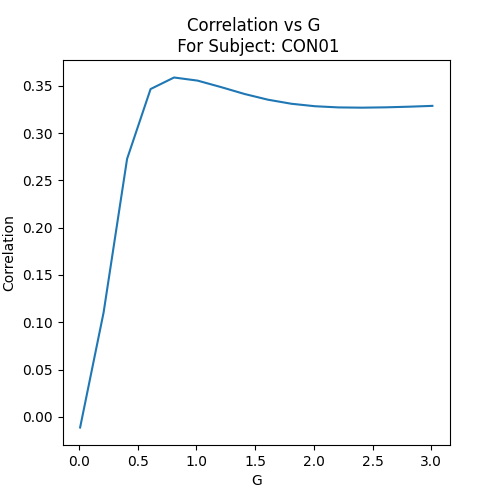

In [26]:
# getting the correlation vs G plot for a single subject
%pylab nbagg
plt.rcParams['figure.figsize'] = [5, 5]
plt.plot(g, PCorr)
plt.xlabel("G")
plt.ylabel("Correlation")
plt.title("Correlation vs G \n For Subject: CON01")
plt.show()